In [7]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [8]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import cat2hpx, pandas_to_fits, my_scaler_forward, cross_match_data_frames
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
import nway_python_api as nway
%matplotlib inline


# LH X-ray catalog

little work with X-ray catalog: duplicates and extended sources

In [9]:
xcat_orig = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')
xcat_orig

Original number of sources: 9500
Number of sources after DL and EL cuts: 9228
Number of sources after DL and EL cuts + duplicates removal: 9215


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
0,SRGe J103744.3+571156,159.434594,57.198788,151.771105,51.782607,2.041112,26414.902344,3.284168e-12,3.904461e-13,15460.503906,1838.058594,4300.765625,0.0,0.0,0.0,1,1,159.436603,57.197499,0.318530,6.785297,0.000011,6.268413e+08,6.270701e+08,0.0,0.0,3.594826,0.427379,20.898417,159.434594,57.198788,853989860956388736,6.040749,1,0,15.749939,-1.0,0,87GB 103431.3+572750,0.830700,BLLac,6.040664,4,1,1,1,12.218000,11.328000,9.144,46.2,51.7,34.4,1,3,1,1237658303278743603,7980433077213351936,6.099201,65741514189,0.318530,0.729711,1.101567,1.786149,134.901685,44.066998,2.527295e-12,5.451755e+19
1,SRGe J110137.5+572926,165.406353,57.490464,147.861359,53.996717,2.144203,5344.646973,1.969860e-12,5.570020e-14,1436.945923,40.631405,666.426941,0.0,0.0,0.0,21,14,165.408362,57.489175,0.433455,41.040825,0.000030,6.268413e+08,6.270701e+08,0.0,0.0,2.156194,0.060969,4.025409,165.406353,57.490464,857143329024245888,7.121849,2,1,10.012074,NaN,0,HD 237963,NaN,Star,7.105646,1,1,0,0,8.146000,8.155000,8.124,47.2,55.3,51.5,1,3,1,1237658302206378052,0,3.844748,64609311305,0.433455,0.766567,1.157204,1.876362,138.528408,46.042071,1.515884e-12,7.056474e+19
2,SRGe J110537.6+585120,166.406669,58.855424,145.639441,53.356921,2.076665,9683.065430,1.505411e-12,9.148949e-14,3063.068848,186.154160,1858.869995,0.0,0.0,0.0,7,4,166.408677,58.854134,0.361642,46.541451,0.000013,6.268413e+08,6.270701e+08,0.0,0.0,1.647812,0.100144,8.487207,166.406669,58.855424,860383349272777344,6.884830,3,0,16.935423,-1.0,0,2MASS J11053761+5851208,0.191000,Seyfert_1,6.883267,1,1,0,1,11.276000,10.261000,7.624,46.9,54.1,57.8,1,3,0,1237655108373839879,7996392488641515520,6.898202,59429013246,0.361642,0.742422,1.120754,1.817260,138.042449,47.467010,1.158473e-12,6.881141e+19
3,SRGe J102349.9+563347,155.958041,56.563186,154.343916,50.594493,2.027046,32979.832031,1.001123e-12,4.287407e-14,7451.697754,319.126190,6800.098145,0.0,0.0,0.0,3,2,155.960049,56.561896,0.161150,96.801712,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,1.095822,0.046930,29.139788,155.958041,56.563186,853150108949817088,6.997905,1,0,17.967112,-1.0,0,2MASX J10234977+5633475,0.230353,Seyfert_1,6.999458,1,1,0,1,12.966000,12.035000,9.582,44.0,48.8,32.1,1,1,0,1237655108371152952,9216701424834203648,6.968698,68241429703,0.300000,0.724683,1.093975,1.773840,133.091566,42.558086,7.704034e-13,7.963453e+19
4,SRGe J105057.2+593215,162.738144,59.537414,147.091312,51.565006,2.041233,7492.464844,9.137326e-13,2.094327e-14,4687.587402,107.442131,4686.813965,0.0,0.0,0.0,4,3,162.740153,59.536125,0.226167,3.579206,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,1.000165,0.022924,23.773006,162.738144,59.537414,861390055247564800,5.119823,2,1,18.398899,-1.0,0,2MASX J10505729+5932144,0.085280,Seyfert_1,5.102316,2,1,1,0,12.489000,11.947000,8.799,48.3,51.5,42.9,2,2,0,1237655368746336397,631642530626168832,5.075234,56915973694,0.318686,0.729755,1.101632,1.786255,135.192778,46.969604,7.031529e-13,7.898503e+19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,SRGe J102315.1+561957,155.813071,56.332561,154.718419,50.650679,12.277468,6.259035,1.637604e-15,6.023096e-16,14.734348,5.419283,8219.958008,0.0,0.0,0.0,8816,7662,155.815079,56.331271,3.503645,66.729698,0.000003,6.268413e+08,6.270701e+08,0.0,0.0,0.001793,0.000659,31.568741,

## histogram of separations (eROxeRO)

In [10]:
xcat_orig_matches = cross_match_data_frames(xcat_orig, xcat_orig, 'RA_fin', 'DEC_fin', 'RA_fin', 'DEC_fin', match_radius = 30, df_prefix = 'matched_')
xcat_orig_matches = xcat_orig_matches.query('matched__sep!=0')
# print(xcat_orig_matches.query("srcname_fin == 'SRGe J103713.2+552723'")['matched__sep'])
# print(xcat_orig_matches.query("srcname_fin == 'SRGe J103714.6+552700'")['matched__sep'])
#xcat_orig_matches.query("srcname_fin == 'SRGe J103713.2+552723'")['matched__srcname_fin']
#xcat_orig_matches.query("srcname_fin == 'SRGe J103714.6+552700'")['matched__srcname_fin']


cross-match radius 30 arcsec
total matches: 9437 out of 9215 x 9215
	 total unique pairs: 8994
	 total non-unique pairs (duplicates in df2): 443


<AxesSubplot:xlabel='matched__sep', ylabel='Count'>

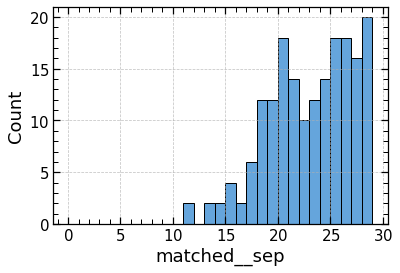

In [11]:
sns.histplot(xcat_orig_matches['matched__sep'], bins=np.arange(0,30,1), label='matched')

Read catalog and create a fits table with positions and positional errors

In [12]:
xcat_orig = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')

positional_error_columns = 'pos_sigma_2d'
print('*'*50)
print('using positional error columns:', positional_error_columns)


columns_to_retain = ['srcname_fin', 'RA_fin', 'DEC_fin', positional_error_columns, 'ML_FLUX_0'] 


xcat = xcat_orig[xcat_orig['DET_LIKE_0']>6]
xcat = xcat[columns_to_retain]
xcat[positional_error_columns] = xcat[positional_error_columns]

xcat.rename(columns={'RA_fin':'RA', 'DEC_fin':'DEC', positional_error_columns:'pos_err', 'srcname_fin': 'ID'}, inplace=True)


print('using corrected positional error columns: 1*', positional_error_columns)
print('*'*50)

xcat['pos_err'] = xcat['pos_err']

**************************************************
using positional error columns: pos_sigma_2d
using corrected positional error columns: 1* pos_sigma_2d
**************************************************


## area and plotting

Resolution of the HEALPix map:
0.05725810686362343 deg per pixel, or
3.435486411817406 arcmin per pixel, or
206.12918470904435 arcsec per pixel
18.12021866047703 sq. deg.


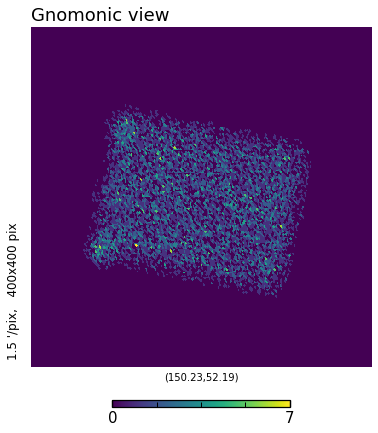

In [13]:
xcat_hp_map = cat2hpx(xcat['RA'], xcat['DEC'], nside=1024, radec=True)
hp.gnomview(xcat_hp_map, rot = [150.23,52.19], xsize = 400)

ERO_SKYAREA = 4*np.pi*(np.rad2deg(1))**2 * np.sum(xcat_hp_map>=1)/len(xcat_hp_map)
print(ERO_SKYAREA, 'sq. deg.')

In [14]:
pandas_to_fits(dataframe = xcat, 
                filename = 'ERO_lhpv_03_23_sd01_a15_g14.fits',
                table_header_name = 'eROSITA',
                sky_area_deg2 = ERO_SKYAREA)

In [15]:
xcat[['RA', 'DEC']].describe().loc[['min', 'max']]

,RA,DEC
min,154.763934,54.124219
max,167.084550,61.236185


## Random catalog

In [16]:
# nway.create_shifted_catalogue(inputfile=data_path+'ERO_lhpv_03_23_sd01_a15_g14.fits', outputfile=data_path+'ERO_lhpv_03_23_sd01_a15_g14_shifted.fits', shift_dec=300, radius=40)

# Catalog with inflated positional errors

In [18]:
xcat_large_err = xcat.copy()
xcat_large_err['pos_err'] = xcat_large_err['pos_err']*1000
pandas_to_fits(dataframe = xcat_large_err, 
                filename = 'ERO_lhpv_03_23_sd01_a15_g14_large_pos_err.fits',
                table_header_name = 'eROSITA',
                sky_area_deg2 = ERO_SKYAREA)